In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'USDSGD'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,wclose,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,1.6950,1.6978,1.6920,1.6940,0.0,1.694450,57.303371,57.303371,60.824742,...,1.69665,1.69045,1.693550,1.69490,-178.450034,-242.438236,-184.817887,464.295411,-388.233001,583.580930
30,14/2/2000,1.6940,1.6978,1.6905,1.6922,0.0,1.693175,37.078652,37.078652,37.078652,...,1.69780,1.69125,1.694525,1.69415,-45.381741,-118.967315,-200.510390,463.216604,-422.364339,573.521348
31,15/2/2000,1.6922,1.6968,1.6922,1.6935,1.0,1.694000,41.095890,51.685393,51.685393,...,1.69730,1.69135,1.694325,1.69450,221.510170,-29.270889,-125.061305,458.987048,-374.731019,549.948957
32,16/2/2000,1.6935,1.7049,1.6935,1.7042,1.0,1.701700,95.138889,95.138889,95.625000,...,1.70085,1.69285,1.696850,1.69920,-503.533569,137.628403,-136.324500,229.465757,-332.115850,483.552456
33,17/2/2000,1.7042,1.7069,1.7018,1.7055,1.0,1.704925,90.476190,91.463415,91.463415,...,1.70590,1.69765,1.701775,1.70435,-507.518797,-653.153153,127.591707,-46.117207,-232.302062,380.075055


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,wclose,so_3,so_4,so_5,so_8,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,1.6978,1.6950,1.6920,1.6940,1.694450,57.303371,57.303371,60.824742,61.111111,...,1.69665,1.69045,1.693550,1.69490,-178.450034,-242.438236,-184.817887,464.295411,-388.233001,583.580930
30,14/2/2000,1.6978,1.6940,1.6905,1.6922,1.693175,37.078652,37.078652,37.078652,58.273381,...,1.69780,1.69125,1.694525,1.69415,-45.381741,-118.967315,-200.510390,463.216604,-422.364339,573.521348
31,15/2/2000,1.6968,1.6922,1.6922,1.6935,1.694000,41.095890,51.685393,51.685393,68.613139,...,1.69730,1.69135,1.694325,1.69450,221.510170,-29.270889,-125.061305,458.987048,-374.731019,549.948957
32,16/2/2000,1.7049,1.6935,1.6935,1.7042,1.701700,95.138889,95.138889,95.625000,95.833333,...,1.70085,1.69285,1.696850,1.69920,-503.533569,137.628403,-136.324500,229.465757,-332.115850,483.552456
33,17/2/2000,1.7069,1.7042,1.7018,1.7055,1.704925,90.476190,91.463415,91.463415,92.222222,...,1.70590,1.69765,1.701775,1.70435,-507.518797,-653.153153,127.591707,-46.117207,-232.302062,380.075055


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 30% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.75752919, 0.75554197, 0.75780409, ..., 0.74099925, 0.43888761,
        0.63395022],
       [0.75752919, 0.75401315, 0.75549746, ..., 0.74078277, 0.43169426,
        0.63202335],
       [0.75599262, 0.75126128, 0.75811164, ..., 0.73993401, 0.44173322,
        0.62750816],
       ...,
       [0.23294407, 0.23604953, 0.23896663, ..., 0.74836891, 0.68246951,
        0.57969037],
       [0.2335587 , 0.23604953, 0.23927418, ..., 0.73942939, 0.67261095,
        0.63183851],
       [0.23279041, 0.23696682, 0.23942796, ..., 0.73415745, 0.66249426,
        0.6605602 ]])

In [10]:
input_data.shape

(5181, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.75752919, 0.75554197, 0.75780409, ..., 0.74099925, 0.43888761,
        0.63395022],
       [0.75752919, 0.75401315, 0.75549746, ..., 0.74078277, 0.43169426,
        0.63202335],
       [0.75599262, 0.75126128, 0.75811164, ..., 0.73993401, 0.44173322,
        0.62750816],
       ...,
       [0.23294407, 0.23604953, 0.23896663, ..., 0.74836891, 0.68246951,
        0.57969037],
       [0.2335587 , 0.23604953, 0.23927418, ..., 0.73942939, 0.67261095,
        0.63183851],
       [0.23279041, 0.23696682, 0.23942796, ..., 0.73415745, 0.66249426,
        0.6605602 ]])

In [13]:
input_data[[0],1:]

array([[0.75554197, 0.75780409, 0.75401315, 0.75575065, 0.6306363 ,
        0.66316875, 0.68284725, 0.56849605, 0.47936646, 0.38174093,
        0.65246804, 0.64127212, 0.56849605, 0.47936646, 0.38174093,
        0.44911377, 0.44872192, 0.43398298, 0.45525102, 0.75783378,
        0.61561774, 0.53172616, 0.75616881, 0.7564607 , 0.75629573,
        0.75766659, 0.49405167, 0.23181713, 0.45693473, 0.74099925,
        0.43888761, 0.63395022]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.75554197, 0.75780409, 0.75401315, ..., 0.74099925,
          0.43888761, 0.63395022]],

        [[0.75401315, 0.75549746, 0.75126128, ..., 0.74078277,
          0.43169426, 0.63202335]],

        [[0.75126128, 0.75811164, 0.75324874, ..., 0.73993401,
          0.44173322, 0.62750816]],

        ...,

        [[0.77159456, 0.76441642, 0.76012842, ..., 0.80799613,
          0.71987714, 0.63694162]],

        [[0.76012842, 0.76549285, 0.76012842, ..., 0.79220185,
          0.7483738 , 0.63702944]],

        [[0.76012842, 0.76303245, 0.76165724, ..., 0.79374714,
          0.763692  , 0.63973625]]],


       [[[0.75401315, 0.75549746, 0.75126128, ..., 0.74078277,
          0.43169426, 0.63202335]],

        [[0.75126128, 0.75811164, 0.75324874, ..., 0.73993401,
          0.44173322, 0.62750816]],

        [[0.75324874, 0.76011072, 0.76960709, ..., 0.69387531,
          0.45071458, 0.61479021]],

        ...,

        [[0.76012842, 0.76549285, 0.76012842, ..., 0.79220185,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4618, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4618/4618 [==============================] - 10s 2ms/step - loss: 0.0039
Epoch 2/5
4618/4618 [==============================] - 9s 2ms/step - loss: 3.5177e-04
Epoch 3/5
4618/4618 [==============================] - 8s 2ms/step - loss: 2.19

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([1.333 , 1.3368, 1.3369, 1.3354, 1.3303, 1.3257, 1.3249, 1.3256,
       1.3275, 1.3215, 1.3223, 1.3208, 1.3177, 1.3127, 1.3127, 1.3127,
       1.315 , 1.3137, 1.3142, 1.32  , 1.322 , 1.3238, 1.3254, 1.3322,
       1.334 , 1.3305, 1.3252, 1.3254, 1.3154, 1.3132, 1.3149, 1.3201,
       1.3239, 1.3257, 1.3246, 1.3213, 1.3246, 1.3264, 1.3286, 1.3233,
       1.3214, 1.3201, 1.3188, 1.3186, 1.3197, 1.3172, 1.3145, 1.3128,
       1.3146, 1.3183, 1.3193, 1.3194, 1.3194, 1.3178, 1.3173, 1.3153,
       1.3105, 1.3129, 1.3137, 1.3119, 1.313 , 1.3131, 1.3156, 1.317 ,
       1.3197, 1.3168, 1.3119, 1.3099, 1.3132, 1.3131, 1.3134, 1.3119,
       1.3121, 1.3121, 1.3174, 1.3262, 1.3276, 1.3297, 1.3291, 1.3288,
       1.3262, 1.3343, 1.3371, 1.3368, 1.336 , 1.3374, 1.3416, 1.3462,
       1.349 , 1.3386, 1.336 , 1.3457, 1.3457, 1.3436, 1.3459, 1.3472,
       1.3414, 1.3464, 1.345 , 1.3424, 1.3431, 1.3484, 1.3471, 1.3407,
       1.3401, 1.3393, 1.3369, 1.3348, 1.3342, 1.3372, 1.3361, 1.3377,
      

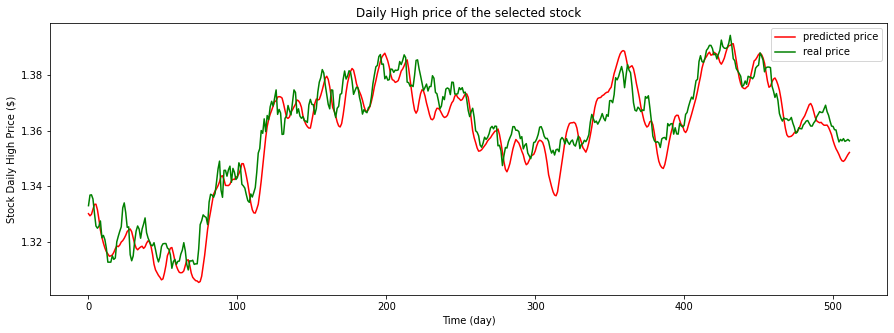

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,1.3330,1.330117,NaN,NaN
1,1.3368,1.329357,1.330117,-0.000760
2,1.3369,1.329893,1.329357,0.000537
3,1.3354,1.331619,1.329893,0.001726
4,1.3303,1.333464,1.331619,0.001844
...,...,...,...,...
507,1.3571,1.348920,1.349151,-0.000231
508,1.3561,1.349452,1.348920,0.000531
509,1.3564,1.350401,1.349452,0.000949
510,1.3568,1.351358,1.350401,0.000957


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,1.3330,1.330117,NaN,NaN,NaN,1.330975,NaN
1,1.3368,1.329357,1.330117,-0.000760,-0.113769,1.334700,0.002799
2,1.3369,1.329893,1.329357,0.000537,0.080303,1.334075,-0.000468
3,1.3354,1.331619,1.329893,0.001726,0.258492,1.330825,-0.002436
4,1.3303,1.333464,1.331619,0.001844,0.277268,1.325300,-0.004152
5,1.3257,1.333532,1.333464,0.000068,0.010270,1.322025,-0.002471
6,1.3249,1.331511,1.333532,-0.002020,-0.304956,1.321500,-0.000397
7,1.3256,1.328140,1.331511,-0.003371,-0.508636,1.323300,0.001362
8,1.3275,1.324204,1.328140,-0.003936,-0.592972,1.322400,-0.000680
9,1.3215,1.321653,1.324204,-0.002551,-0.386089,1.319400,-0.002269


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

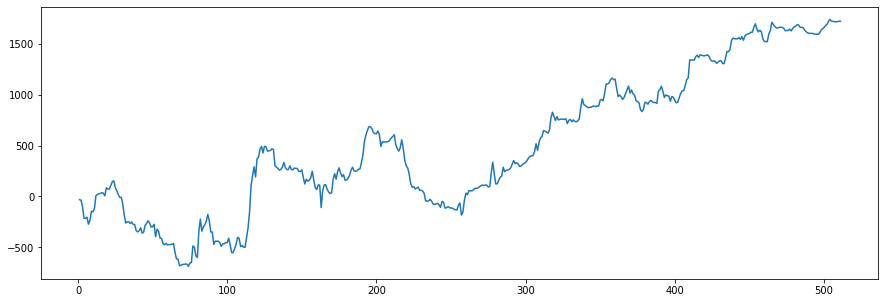

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

1.0875439334345613

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.0901639344262295

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 870.3776928324091 , from day 195 , to day 257
